<a href="https://colab.research.google.com/github/WHU-Peter/Artifical_Intelligence/blob/master/Shopee_data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
from six.moves import urllib
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import subprocess

import plotly.express as px
import random
import matplotlib.pyplot as plt
import cv2
try:
  import fasttext
except:
  !pip install fasttext
  import fasttext
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
try:
  from pycountry import languages
except:
  !pip install pycountry
  from pycountry import languages
from collections import Counter

!pip install tensorflow==1.15
# Install bert-as-service
!pip install bert-serving-server==1.10.0
!pip install bert-serving-client==1.10.0
# Download and unzip the pre-trained model
!wget http://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

from sklearn.cluster import DBSCAN
from bert_serving.client import BertClient

     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093323 sha256=f862d913954fc8cf0066a867e807b5a8849d7183804b4338700b83d42b147cd4
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
--2021-04-12 17:25:57--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  66.4MB/s    in 1.9s    

2021-04-12 17:25:59 (66.4 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]

     |████████████████████████████████| 10.1MB 9.8MB/s

下载数据

In [2]:
DOWNLOAD_URL = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/24286/1878097/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1618502177&Signature=rHKGEh9jCJl7qs4AI%2B7WpqcRcnM7gJp6zq7oiLeyKmlnS9XVA2Yvqy9mEE0UFv7wOGAcbULR%2BnyJyx9fcA8ef3GP9DtfMP7DgeiN35PWusfUNKOHn8hpCgH0mQ%2BP9BLZjGCY7OD0SmwmD%2F983IQg1B6RvQ7GyzNsM9SQROEvCi5Gh2ZTBcbe%2Fh908s1brgQUekSXkYmV%2BJkjyoBiGQIMJoSxPxPmSP4kBB%2FOB8knc6ox273JZb08DAtpn5LlF7tUpzfq6bZP8QWBKEecv4%2BVwccTYKdNIQXl8qYepniqXvTgPeuuCaZDSV6ddjLb5cqPb2hoPVCAPL%2BxxDOFfzFkEQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dshopee-product-matching.zip"

DATA_PATH = "datasets/shopee"

def fetch_housing_data(DOWNLOAD_URL=DOWNLOAD_URL, DATA_PATH=DATA_PATH):
  if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)
  zip_path = os.path.join(DATA_PATH, "shopee.zip")
  urllib.request.urlretrieve(DOWNLOAD_URL, zip_path)
  shop_zip = zipfile.ZipFile(zip_path)
  shop_zip.extractall(path=DATA_PATH)
  shop_zip.close()
 
fetch_housing_data()

读入训练集数据

In [3]:
def load_train_data(DATA_PATH=DATA_PATH):
  csv_path = os.path.join(DATA_PATH, "train.csv")
  return pd.read_csv(csv_path)

shopee_train_data_set = load_train_data()

In [4]:
# 查看表头和前几行数据
shopee_train_data_set.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [5]:
# 查看各个字段类型
shopee_train_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


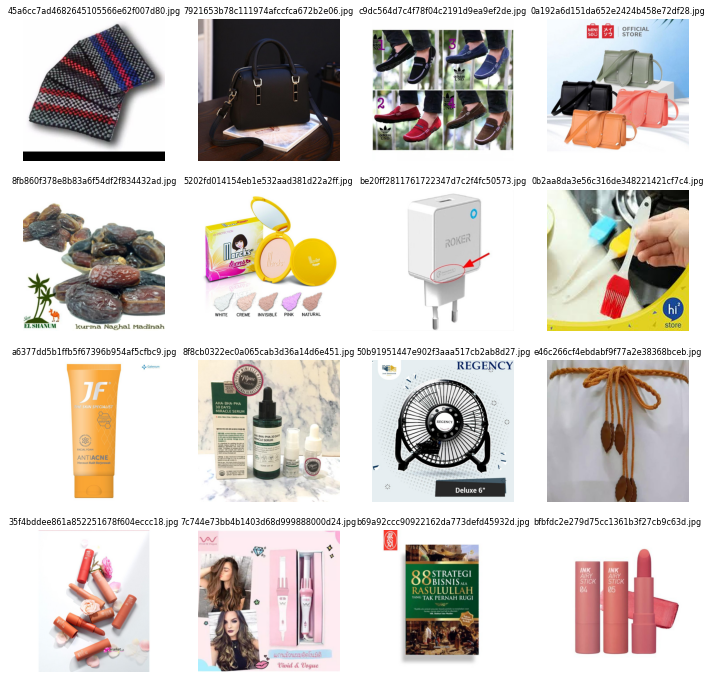

In [19]:
# 抽样查看商品图片
def plot_images(images_number):
    plot_list = shopee_train_data_set['image'].sample(n=images_number).tolist()
    size = np.sqrt(images_number)
    if int(size)*int(size) < images_number:
        size = int(size) + 1
        
    plt.figure(figsize=(12, 12))
    
    ind=0
    for image_id in plot_list:
        plt.subplot(size, size, ind + 1)
        image = cv2.imread(str(Path('datasets/shopee/train_images/', image_id)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(image_id, fontsize=8)
        plt.axis("off")
        ind+=1
    plt.show()

plot_images(16)

In [9]:
# 查看样本总数和目标变量的数量
n_labels = len(shopee_train_data_set["label_group"].unique())
n_ex = len(shopee_train_data_set)
print(f'Num of training examples: {n_ex}\nNum of labels: {n_labels}')

Num of training examples: 34250
Num of labels: 11014


In [10]:
# 查看样本在各个目标变量上的分布
df_cnt = shopee_train_data_set["label_group"].value_counts().reset_index()
df_cnt.columns = ["group_name", "num_of_objects"]
df_cnt["group_name"] = df_cnt["group_name"].astype(str)

fig = px.histogram(df_cnt, x="num_of_objects", nbins=10,log_y=True)
fig.show()

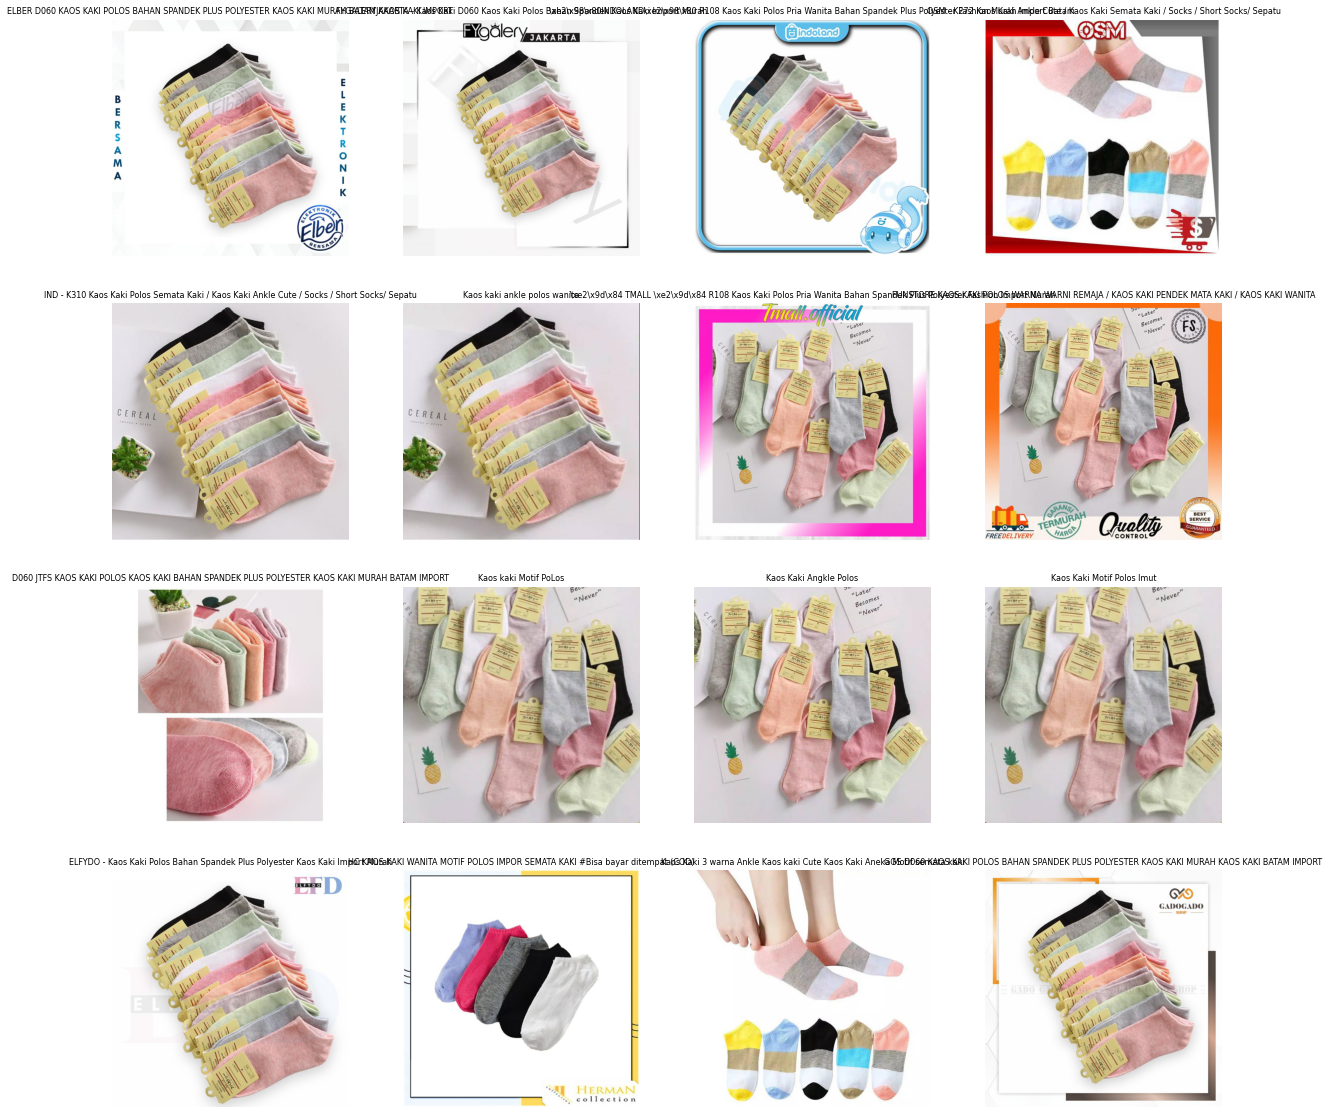

In [22]:
# 找一个属于同类的商品，查看商品图片
def plot_groups(list_large_groups, images_number=16):
    group_id = random.sample(list_large_groups, 1)[0]
    plot_list = shopee_train_data_set[shopee_train_data_set["label_group"]==group_id][['image', 'title']].sample(n=images_number)
    size = np.sqrt(images_number)
    if int(size)*int(size) < images_number:
        size = int(size) + 1
        
    plt.figure(figsize=(20, 20))
    
    ind=0
    for _, item in plot_list.iterrows():
        plt.subplot(size, size, ind + 1)
        image = cv2.imread(str(Path('datasets/shopee/train_images/', item["image"])))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(item["title"], fontsize=8)
        plt.axis("off")
        ind+=1
    plt.show()

df_g =  shopee_train_data_set["label_group"].value_counts().reset_index()
list_large_groups = list(df_g[df_g["label_group"]>20]["index"])
plot_groups(list_large_groups, images_number=16)

In [23]:
# 查看商品标题的语言类型分布
PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

sentences = shopee_train_data_set['title'].tolist()
predictions = model.predict(sentences)
language_code = [x[0].split("__label__")[1] for x,y in zip(predictions[0], predictions[1]) if y[0]>0.5]
language_name = [languages.get(alpha_2=x) for x in language_code]
language_name = [x.name if x else "none" for x in language_name]

cnt_lang = Counter(language_name)
cnt_lang.most_common()

[('English', 3975),
 ('Indonesian', 1362),
 ('Japanese', 211),
 ('Malay (macrolanguage)', 176),
 ('German', 75),
 ('Spanish', 25),
 ('Italian', 18),
 ('French', 17),
 ('Portuguese', 9),
 ('Polish', 6),
 ('Chinese', 6),
 ('Dutch', 6),
 ('Swedish', 5),
 ('Esperanto', 3),
 ('Turkish', 2),
 ('Croatian', 2),
 ('Serbian', 1),
 ('Tagalog', 1),
 ('Vietnamese', 1),
 ('none', 1),
 ('Finnish', 1),
 ('Catalan', 1),
 ('Russian', 1),
 ('Romanian', 1)]